### Sentence classification using CNN with Keras

In [1]:
import json
import os
import numpy as np
import itertools

from sklearn.metrics import classification_report, confusion_matrix

import keras
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from keras.engine import Input
from keras.layers import Embedding, merge
from keras.datasets import imdb
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPool1D, Conv1D, Embedding
from keras.layers.merge import Concatenate
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import regularizers

import gensim
from gensim.models import word2vec

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.
C:\Anaconda\envs\py35\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words= None, start_char=None, oov_char=None, index_from=None)

In [3]:
unique, counts = np.unique(y_train, return_counts=True)
print('Train labels')
dict(zip(unique, counts))

Train labels


{0: 12500, 1: 12500}

In [4]:
unique, counts = np.unique(y_test, return_counts=True)
print('Test labels')
dict(zip(unique, counts))

Test labels


{0: 12500, 1: 12500}

In [5]:
train_lens = np.array([len(s) for s in x_train])

In [6]:
print('max review length:', max(train_lens))
print('min review length:', min(train_lens))

max review length: 2493
min review length: 10


In [7]:
print(x_train[11])

[51, 10, 1607, 11, 17, 10, 66, 52, 361, 1395, 18, 51, 10, 216, 9, 10, 1703, 12, 1, 17, 13, 326, 3, 173, 326, 71, 48, 10, 870, 1, 153, 68, 75, 1, 7409, 319, 13, 28, 4, 1, 246, 1, 62, 13, 35, 376, 9, 97, 154, 15, 3, 907, 17, 546, 15, 1, 1493, 18, 11, 28, 6, 21, 3, 209, 9, 6, 3, 1319, 988, 4, 2999, 1, 422, 6, 70, 2215, 546, 15, 28, 152, 33, 97, 760, 376, 17, 100, 348, 5305, 10, 199, 9, 2238, 2, 3, 317, 43, 4, 454]


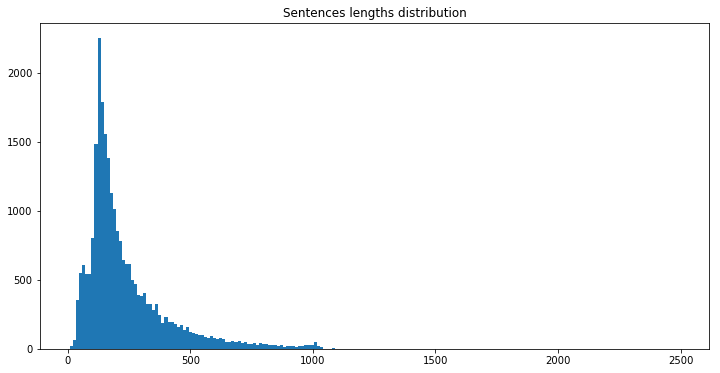

In [8]:
plt.figure(figsize=(12, 6))
plt.title('Sentences lengths distribution')
h = plt.hist(train_lens, bins = 200)

In [9]:
max_sentence_len = 500

In [10]:
x_train = sequence.pad_sequences(x_train, maxlen=max_sentence_len, padding="post", truncating="post")
x_test = sequence.pad_sequences(x_test, maxlen=max_sentence_len, padding="post", truncating="post")

In [11]:
train_lens = np.array([len(s) for s in x_train])

In [12]:
print('max review length:', max(train_lens))
print('min review length:', min(train_lens))

max review length: 500
min review length: 500


In [13]:
print(x_train[11])

[  51   10 1607   11   17   10   66   52  361 1395   18   51   10  216    9
   10 1703   12    1   17   13  326    3  173  326   71   48   10  870    1
  153   68   75    1 7409  319   13   28    4    1  246    1   62   13   35
  376    9   97  154   15    3  907   17  546   15    1 1493   18   11   28
    6   21    3  209    9    6    3 1319  988    4 2999    1  422    6   70
 2215  546   15   28  152   33   97  760  376   17  100  348 5305   10  199
    9 2238    2    3  317   43    4  454    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0  

In [14]:
vocabulary = imdb.get_word_index()
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
vocabulary_inv[0] = "_pad"

In [15]:
vocabulary

{'goliaths': 39020,
 'establish': 6640,
 'tiger': 4911,
 'barfing': 36072,
 'charater': 85274,
 '\x97resembled': 73592,
 'isla': 26385,
 'reble': 88564,
 'nallavan': 67407,
 'flique': 72736,
 "this's": 50144,
 'hbo2': 74594,
 'subsequences': 86769,
 'militants': 39754,
 "hampton's": 46135,
 'hillsborough': 42297,
 'lookouts': 52328,
 'tormenting': 22335,
 'varmint': 65910,
 'bekhti': 59326,
 'wort': 66728,
 'glaucoma': 74398,
 "'geek'": 64789,
 'guiltily': 56687,
 'interjected': 30993,
 'robotronic': 62562,
 'suavity': 45411,
 'thesaurus': 34740,
 'father': 333,
 'bullets': 3586,
 'shipbuilding': 76287,
 'contentions': 63373,
 'prefered': 56655,
 'turnbill': 86681,
 'shamble': 28365,
 'gundam': 4667,
 'zwrite': 79237,
 'benkai': 61610,
 "arne't": 72466,
 'weinberger': 72992,
 'apparent': 1731,
 'massacred': 18707,
 'elegius': 84086,
 "liszt's": 45886,
 'cavett': 33429,
 'forsyth': 22477,
 'histrionics': 12578,
 'monstroid': 81922,
 'vertebrae': 88025,
 'typhoon': 37877,
 'liaised': 532

In [16]:
vocabulary_inv

{0: '_pad',
 1: 'the',
 2: 'and',
 3: 'a',
 4: 'of',
 5: 'to',
 6: 'is',
 7: 'br',
 8: 'in',
 9: 'it',
 10: 'i',
 11: 'this',
 12: 'that',
 13: 'was',
 14: 'as',
 15: 'for',
 16: 'with',
 17: 'movie',
 18: 'but',
 19: 'film',
 20: 'on',
 21: 'not',
 22: 'you',
 23: 'are',
 24: 'his',
 25: 'have',
 26: 'he',
 27: 'be',
 28: 'one',
 29: 'all',
 30: 'at',
 31: 'by',
 32: 'an',
 33: 'they',
 34: 'who',
 35: 'so',
 36: 'from',
 37: 'like',
 38: 'her',
 39: 'or',
 40: 'just',
 41: 'about',
 42: "it's",
 43: 'out',
 44: 'has',
 45: 'if',
 46: 'some',
 47: 'there',
 48: 'what',
 49: 'good',
 50: 'more',
 51: 'when',
 52: 'very',
 53: 'up',
 54: 'no',
 55: 'time',
 56: 'she',
 57: 'even',
 58: 'my',
 59: 'would',
 60: 'which',
 61: 'only',
 62: 'story',
 63: 'really',
 64: 'see',
 65: 'their',
 66: 'had',
 67: 'can',
 68: 'were',
 69: 'me',
 70: 'well',
 71: 'than',
 72: 'we',
 73: 'much',
 74: 'been',
 75: 'bad',
 76: 'get',
 77: 'will',
 78: 'do',
 79: 'also',
 80: 'into',
 81: 'people',
 82:

In [17]:
print(vocabulary_inv[83326])

orchestras


In [18]:
print(vocabulary['orchestras'])

83326


In [19]:
print("Traing data shape:", x_train.shape)
print("Test data shape:", x_test.shape)
print("Vocabulary size:", len(vocabulary_inv))

Traing data shape: (25000, 500)
Test data shape: (25000, 500)
Vocabulary size: 88585


#### Embedding intuition

Embedding expects (batch_size, sequence_length)

In [20]:
model = Sequential()
model.add(Embedding(input_dim = len(vocabulary_inv), output_dim = 32, input_length=1))

data_in = np.zeros((1, 1))
data_out =  model.predict(data_in)

print('Data in', data_in.shape)
print('Data out',data_out.shape)
print(data_out)

Data in (1, 1)
Data out (1, 1, 32)
[[[-0.04945351 -0.01555111  0.00792786 -0.00631783  0.02398801  0.03383007
   -0.01011925  0.03354141 -0.03999684 -0.01954479  0.02075784 -0.00176959
   -0.02936645 -0.02132448 -0.01829553 -0.02445862  0.04353912  0.02832991
   -0.00035477 -0.02244353 -0.00304531  0.02987088  0.00426165  0.02063164
    0.0191722  -0.0005989   0.01286094  0.04530339  0.04986738 -0.01057338
    0.0208518   0.02421054]]]


In [21]:
model = Sequential()
model.add(Embedding(input_dim = len(vocabulary_inv), output_dim = 32, input_length=50))

data_in = np.random.randint(0, len(vocabulary_inv), size = (1, 50))
data_out =  model.predict(data_in)

print('Data in', data_in.shape)
print('Data out',data_out.shape)
print(data_out)

Data in (1, 50)
Data out (1, 50, 32)
[[[ 0.02716014 -0.01319461 -0.02110037 ..., -0.0143709   0.00291054
   -0.01213707]
  [ 0.03572384 -0.04962901  0.04342823 ...,  0.03558773  0.033586
    0.01029308]
  [ 0.01489705 -0.03259496 -0.02421235 ...,  0.01505915 -0.03644056
    0.0047553 ]
  ..., 
  [-0.02230473  0.01303217 -0.02873441 ..., -0.01626735 -0.01742644
    0.01057212]
  [-0.01696382 -0.03579547  0.01739556 ...,  0.04762895  0.00700978
    0.00022775]
  [ 0.00744102 -0.02359619  0.01047375 ...,  0.0372368  -0.04914365
    0.04514537]]]


#### Convolution 1D

Convolution expects (batch_size, steps, input_dim)

In [22]:
model = Sequential()
model.add(Embedding(input_dim = len(vocabulary_inv), output_dim = 32, input_length=50))
model.add(
    Conv1D(
        filters = 3, 
        kernel_size = 5,
        padding='valid', # no padding
        activation='relu',
        strides=1, 
        name = 'conv1')
)

data_in = np.random.randint(0, len(vocabulary_inv), size = (1, 50))
data_out =  model.predict(data_in)

print('Data in', data_in.shape)
print('Data out',data_out.shape)
print(data_out)

Data in (1, 50)
Data out (1, 46, 3)
[[[ 0.01309166  0.01381969  0.        ]
  [ 0.          0.          0.05678263]
  [ 0.          0.02298166  0.        ]
  [ 0.00735859  0.          0.        ]
  [ 0.00426455  0.02189966  0.00562029]
  [ 0.02743627  0.02822439  0.        ]
  [ 0.00114766  0.04718206  0.        ]
  [ 0.03158069  0.08503895  0.        ]
  [ 0.00808153  0.07945781  0.04008229]
  [ 0.          0.01944435  0.01972958]
  [ 0.          0.03426027  0.01210012]
  [ 0.          0.03038787  0.00997369]
  [ 0.          0.00992939  0.08939212]
  [ 0.          0.06571374  0.        ]
  [ 0.01409546  0.          0.01598177]
  [ 0.11078098  0.          0.03890799]
  [ 0.13963057  0.          0.        ]
  [ 0.03466163  0.02992011  0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.07091082  0.0355977 ]
  [ 0.00194326  0.          0.04294358]
  [ 0.          0.          0.00690814]
  [ 0.00571002  0.          0.01068309]
  [ 

In [23]:
l = model.get_layer('conv1')
print('Conv1D weights shape', l.get_weights()[0].shape)
print('Conv1D bias shape', l.get_weights()[1].shape)

Conv1D weights shape (5, 32, 3)
Conv1D bias shape (3,)


#### Model with trainable embeddings

In [24]:
embedding_len = 64

In [25]:
model_input = Input(shape=(max_sentence_len,))

emb = Embedding(
    input_dim = len(vocabulary_inv), 
    output_dim = embedding_len,
    input_length=max_sentence_len)(model_input)

conv1 = Conv1D(
        filters = 8, 
        kernel_size = 3,
        padding='valid',
        activation='relu',
        strides=1)(emb)
conv1 = MaxPool1D(pool_size=2)(conv1)
conv1 = Flatten()(conv1)

conv2 = Conv1D(
        filters = 8, 
        kernel_size = 5,
        padding='valid',
        activation='relu',
        strides=1)(emb)
conv2 = MaxPool1D(pool_size=2)(conv2)
conv2 = Flatten()(conv2)

conc = Concatenate()([conv1, conv2])
conc = Dropout(0.5)(conc)

den = Dense(128,  kernel_regularizer=regularizers.l2(0.01), activation='relu')(conc)
den = Dropout(0.5)(den)

model_output = Dense(1, activation='sigmoid')(den)
model = Model(model_input, model_output)

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 500)           0                                            
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 500, 64)       5669440     input_1[0][0]                    
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 498, 8)        1544        embedding_4[0][0]                
____________________________________________________________________________________________________
conv1d_2 (Conv1D)                (None, 496, 8)        2568        embedding_4[0][0]                
___________________________________________________________________________________________

In [26]:
model.compile(
    loss="binary_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy"])

In [27]:
earlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 5, verbose = 0, mode = 'auto')
checkpoint = keras.callbacks.ModelCheckpoint(
    'cnn_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [28]:
hist = model.fit(
    x_train, 
    y_train, 
    batch_size=64, 
    epochs=10, 
    validation_data=(x_test, y_test), 
    verbose=2,
    callbacks = [earlyStopping, checkpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
Epoch 00000: val_acc improved from -inf to 0.87216, saving model to cnn_model.h5
8s - loss: 0.6569 - acc: 0.6932 - val_loss: 0.3984 - val_acc: 0.8722
Epoch 2/10
Epoch 00001: val_acc improved from 0.87216 to 0.87748, saving model to cnn_model.h5
7s - loss: 0.3165 - acc: 0.9136 - val_loss: 0.3733 - val_acc: 0.8775
Epoch 3/10
Epoch 00002: val_acc did not improve
7s - loss: 0.2080 - acc: 0.9564 - val_loss: 0.4849 - val_acc: 0.8436
Epoch 4/10
Epoch 00003: val_acc did not improve
7s - loss: 0.1456 - acc: 0.9754 - val_loss: 0.4806 - val_acc: 0.8581
Epoch 5/10
Epoch 00004: val_acc did not improve
7s - loss: 0.1170 - acc: 0.9841 - val_loss: 0.5541 - val_acc: 0.8536
Epoch 6/10
Epoch 00005: val_acc did not improve
7s - loss: 0.1081 - acc: 0.9868 - val_loss: 0.6701 - val_acc: 0.8325
Epoch 7/10
Epoch 00006: val_acc did not improve
7s - loss: 0.1031 - acc: 0.9897 - val_loss: 0.7501 - val_acc: 0.8368
Epoch 8/10
Epoch 00007: val_acc did not 

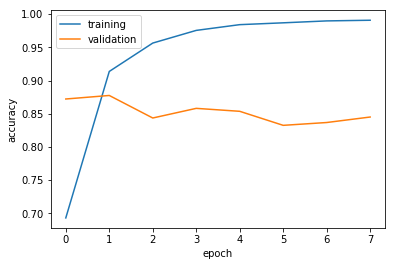

In [29]:
plt.plot(hist.history['acc'], label='training')
plt.plot(hist.history['val_acc'], label='validation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

In [30]:
y_pred_proba = model.predict(x_test)
y_pred_test = np.zeros(y_pred_proba.shape)
y_pred_test[y_pred_proba > 0.5] = 1

In [31]:
print(classification_report(y_test, y_pred_test))

             precision    recall  f1-score   support

          0       0.85      0.84      0.84     12500
          1       0.84      0.85      0.85     12500

avg / total       0.85      0.85      0.85     25000



In [32]:
print(confusion_matrix(y_test, y_pred_test))

[[10548  1952]
 [ 1922 10578]]


#### Model with static embeddings

In [33]:
# recover the sentences from the integer encoding
train_sentences = [[vocabulary_inv[w] for w in s] for s in x_train]
test_sentences = [[vocabulary_inv[w] for w in s] for s in x_test]

In [34]:
train_sentences[0]

['this',
 'film',
 'was',
 'just',
 'brilliant',
 'casting',
 'location',
 'scenery',
 'story',
 'direction',
 "everyone's",
 'really',
 'suited',
 'the',
 'part',
 'they',
 'played',
 'and',
 'you',
 'could',
 'just',
 'imagine',
 'being',
 'there',
 'robert',
 "redford's",
 'is',
 'an',
 'amazing',
 'actor',
 'and',
 'now',
 'the',
 'same',
 'being',
 'director',
 "norman's",
 'father',
 'came',
 'from',
 'the',
 'same',
 'scottish',
 'island',
 'as',
 'myself',
 'so',
 'i',
 'loved',
 'the',
 'fact',
 'there',
 'was',
 'a',
 'real',
 'connection',
 'with',
 'this',
 'film',
 'the',
 'witty',
 'remarks',
 'throughout',
 'the',
 'film',
 'were',
 'great',
 'it',
 'was',
 'just',
 'brilliant',
 'so',
 'much',
 'that',
 'i',
 'bought',
 'the',
 'film',
 'as',
 'soon',
 'as',
 'it',
 'was',
 'released',
 'for',
 'retail',
 'and',
 'would',
 'recommend',
 'it',
 'to',
 'everyone',
 'to',
 'watch',
 'and',
 'the',
 'fly',
 'fishing',
 'was',
 'amazing',
 'really',
 'cried',
 'at',
 'the',


Train our own embeddings

In [35]:
embedding_model = word2vec.Word2Vec(
    train_sentences + test_sentences,  workers=6, size=embedding_len,  min_count=1,  window=5, sample=1e-3)

In [36]:
embedding_model.init_sims(replace=True)

In [37]:
w_emb = embedding_model['zillionaire']
print('Embedding shape', w_emb.shape)
print(w_emb)

Embedding shape (64,)
[ 0.07486107 -0.07109833  0.21858199 -0.18363045 -0.03222381 -0.07652404
 -0.03070534 -0.05567903  0.07454121 -0.03700343  0.25541753  0.02319675
  0.08640084  0.12984319 -0.31398538 -0.02053308  0.01367174 -0.10044046
 -0.07328158 -0.00373057  0.04369634 -0.18444814  0.04494422  0.14454557
  0.00981944 -0.15654723 -0.01499654 -0.00170562  0.03771282  0.07963956
 -0.05897016 -0.00538747  0.21304087  0.02321156  0.07117281 -0.02764203
  0.10280145 -0.06515261 -0.22716241 -0.10832576 -0.10685285 -0.23433995
  0.20360346  0.02027545 -0.18634363 -0.0931175   0.02315984 -0.13177778
 -0.0074973  -0.18230969  0.01297371  0.10568278 -0.00788195 -0.13129999
 -0.30365482 -0.05206598 -0.14015244 -0.13325703 -0.12440516  0.07183587
  0.03152344 -0.16988887  0.20165037 -0.07389233]


Use the static embedding vectors as the input features

In [38]:
x_train = np.stack([np.stack([embedding_model[word] for word in sentence]) for sentence in train_sentences])
x_test = np.stack([np.stack([embedding_model[word] for word in sentence]) for sentence in test_sentences])

In [39]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (25000, 500, 64)
x_test shape: (25000, 500, 64)


In [40]:
model_input = Input(shape=(max_sentence_len, embedding_len))

conv1 = Conv1D(
        filters = 8, 
        kernel_size = 3,
        padding='valid',
        activation='relu',
        strides=1)(model_input)
conv1 = MaxPool1D(pool_size=2)(conv1)
conv1 = Flatten()(conv1)

conv2 = Conv1D(
        filters = 8, 
        kernel_size = 5,
        padding='valid',
        activation='relu',
        strides=1)(model_input)
conv2 = MaxPool1D(pool_size=2)(conv2)
conv2 = Flatten()(conv2)

conc = Concatenate()([conv1, conv2])
conc = Dropout(0.5)(conc)

den = Dense(128, activation='relu')(conc)
den = Dropout(0.5)(den)

model_output = Dense(1, activation='sigmoid')(den)
model = Model(model_input, model_output)

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 500, 64)       0                                            
____________________________________________________________________________________________________
conv1d_3 (Conv1D)                (None, 498, 8)        1544        input_2[0][0]                    
____________________________________________________________________________________________________
conv1d_4 (Conv1D)                (None, 496, 8)        2568        input_2[0][0]                    
____________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)   (None, 249, 8)        0           conv1d_3[0][0]                   
___________________________________________________________________________________________

In [41]:
model.compile(
    loss="binary_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy"])

In [42]:
earlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 5, verbose = 0, mode = 'auto')
checkpoint = keras.callbacks.ModelCheckpoint(
    'cnn_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [43]:
hist = model.fit(
    x_train, 
    y_train, 
    batch_size=64, 
    epochs=10, 
    validation_data=(x_test, y_test), 
    verbose=2,
    callbacks = [earlyStopping, checkpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
Epoch 00000: val_acc improved from -inf to 0.83688, saving model to cnn_model.h5
11s - loss: 0.5269 - acc: 0.7198 - val_loss: 0.3758 - val_acc: 0.8369
Epoch 2/10
Epoch 00001: val_acc improved from 0.83688 to 0.85416, saving model to cnn_model.h5
10s - loss: 0.3759 - acc: 0.8347 - val_loss: 0.3354 - val_acc: 0.8542
Epoch 3/10
Epoch 00002: val_acc improved from 0.85416 to 0.86156, saving model to cnn_model.h5
10s - loss: 0.3437 - acc: 0.8534 - val_loss: 0.3270 - val_acc: 0.8616
Epoch 4/10
Epoch 00003: val_acc did not improve
10s - loss: 0.3252 - acc: 0.8626 - val_loss: 0.3315 - val_acc: 0.8546
Epoch 5/10
Epoch 00004: val_acc improved from 0.86156 to 0.86792, saving model to cnn_model.h5
11s - loss: 0.3139 - acc: 0.8696 - val_loss: 0.3159 - val_acc: 0.8679
Epoch 6/10
Epoch 00005: val_acc improved from 0.86792 to 0.87172, saving model to cnn_model.h5
11s - loss: 0.2965 - acc: 0.8741 - val_loss: 0.3058 - val_acc: 0.8717
Epoch 7/10

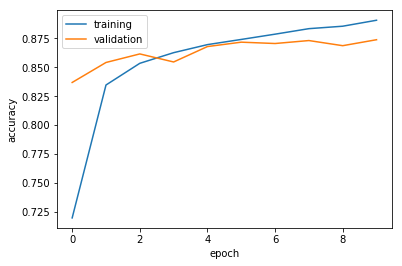

In [44]:
plt.plot(hist.history['acc'], label='training')
plt.plot(hist.history['val_acc'], label='validation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

In [45]:
y_pred_proba = model.predict(x_test)
y_pred_test = np.zeros(y_pred_proba.shape)
y_pred_test[y_pred_proba > 0.5] = 1

In [46]:
print(classification_report(y_test, y_pred_test))

             precision    recall  f1-score   support

          0       0.90      0.84      0.87     12500
          1       0.85      0.91      0.88     12500

avg / total       0.88      0.87      0.87     25000



In [47]:
print(confusion_matrix(y_test, y_pred_test))

[[10515  1985]
 [ 1169 11331]]
